# Data loader for Detectron2

In [ ]:
import os
import json
import cv2
import random
import glob
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, print_instances_class_histogram

In [ ]:
def get_detectron2_dicts(img_dir, modality, thing_classes):
    """
    Generate detectron2 formatted dict from dastaset
    For now create separate dataset dict for PT and CT images
    Inputs:
        img_dir (string): path to the dataset directory
        modality (string): 'PT' or 'CT'
        thing_classes (dict): mapping to go from ROI class to integer id
    Returns:
        dataset_dicts (dict): formatted dataset dict
    """
    json_file = os.path.join(img_dir, "global_dict.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
        
    dataset_dicts = []
    total_patients = len(imgs_anns.keys())
    # iterate over each patient in dataset
    for idx, patient in enumerate(tqdm(imgs_anns.keys())):
        m = imgs_anns[patient][modality]
        all_frame_fp = glob.glob(m['fp'] + "/*.jpeg")

        # iterate over each frame
        for jdx, frame_fp in enumerate(all_frame_fp):
            record = {}
            
            # get the slice number of frame jpeg
            slice_num = int(re.findall(r'\d+', frame_fp)[-1])
            height, width = cv2.imread(frame_fp).shape[:2]
            
            record["file_name"] = frame_fp
            record["image_id"] = idx * total_patients + jdx
            record["height"] = height
            record["width"] = width
            
            roi_keys = m['rois'].keys()
            objs = []
            
            # iterate over each ROI
            for _, roi in enumerate(roi_keys):
                # skip if roi is not in thing_classes
                if roi not in thing_classes:
                    continue
                
                # get integer id for roi
                category_id = thing_classes[roi]
                contours = np.array(m['rois'][roi][slice_num])
                polys = []
                px = []
                py = []
                
                # iterate over each set of x,y polygon coordinates
                for item in contours:
                    item = np.array(item)
                    # convert list of tuples to list e.g. [x1,y1,x2,y2]
                    polys.append([int(val) for t in item for val in t])
                    px.extend(item[:,0])
                    py.extend(item[:,1])
                    
                if len(px) != 0:
                    obj = {
                        "bbox": [int(np.min(px)), int(np.min(py)),
                                 int(np.max(px)), int(np.max(py))],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": polys,
                        "category_id": category_id,
                    }
                    objs.append(obj)
        
            record["annotations"] = objs
            dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
# specify name/path of dataset and modality
img_dir = 'image_dataset'
modality = 'CT'

# define mapping for ROI classes
# NOTE: ignoring SUV Peak Sphere 1 and SUV Sphere 1 - SUV Sphere Max Value
# NOTE: should we do semantic segmentation and keep tumor, tumor2, and tumor3 or do instance and merge tumor classes
thing_classes = {'Inter':0,
                 'Threshold':1,
                 'Tumor':2,
                 'Tumor2':3,
                 'Tumor3':4,
                 'Bladder':5,
                 'L seminal':6,
                 'R seminal':7,
                 'TURP urethra':8}

# set colors for each ROI
# generated using https://mokole.com/palette.html
thing_colors = [[0, 100, 0],
               [188, 143, 143],
               [255, 69, 0],
               [255, 215, 0],
               [0, 255, 0],
               [65, 105, 225],
               [0, 255, 255],
               [0, 0, 255],
               [255, 20, 147]]

# register dataset into Detectron2 catalog, second arg needs to be a function
DatasetCatalog.register("prostate_dataset", lambda: get_detectron2_dicts(img_dir, modality))

# set metadata for registered dataset
# thing_classes is for instance segmentation while stuff_classes is for semantic
# https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets
MetadataCatalog.get("prostate_dataset").thing_classes = list(thing_classes.keys())
MetadataCatalog.get("prostate_dataset").thing_colors = list(thing_classes.keys())
prostate_metadata = MetadataCatalog.get("prostate_dataset")

In [ ]:
# get dastaset dicts so can visualize below
dataset_dicts = get_detectron2_dicts(img_dir, modality, thing_classes)

In [ ]:
# make plots bigger
plt.rcParams["figure.figsize"]=10,10

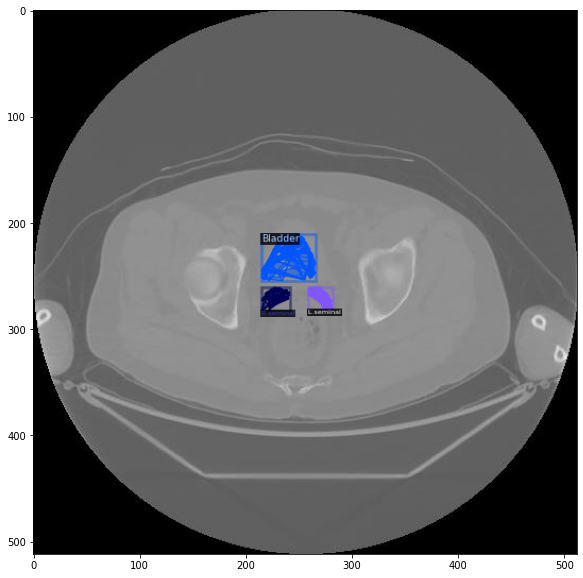

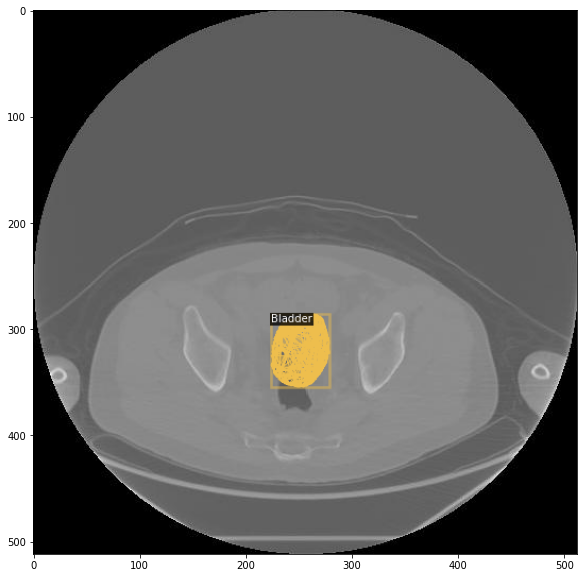

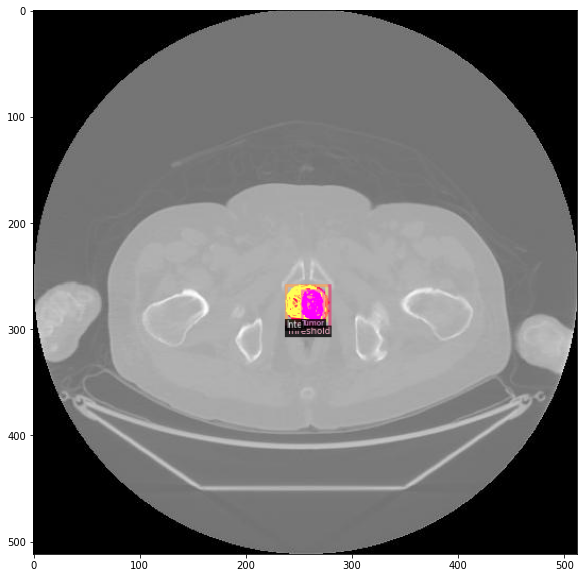

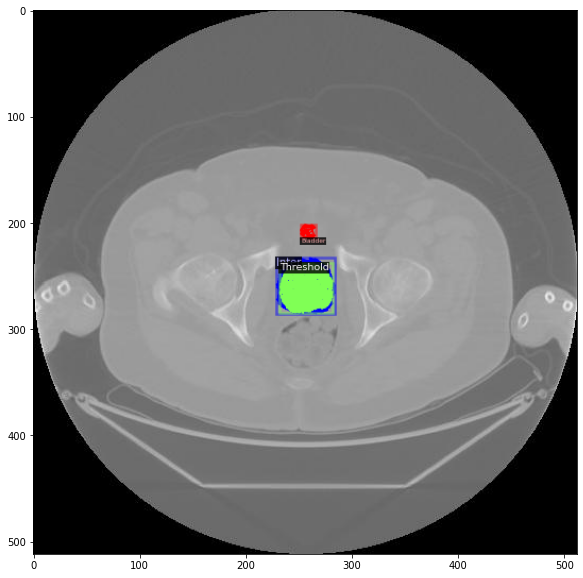

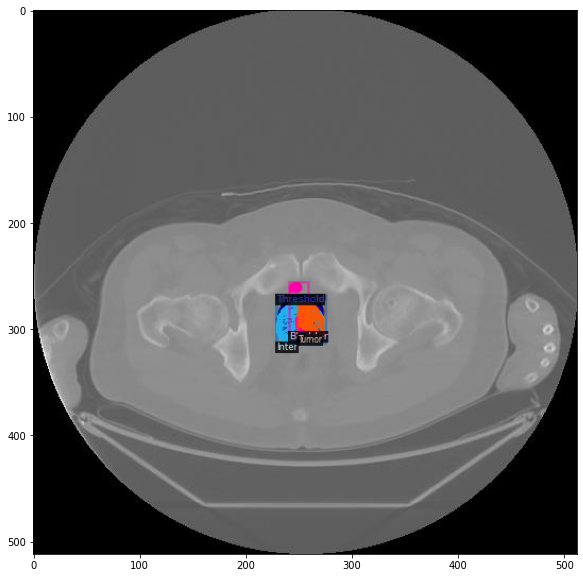

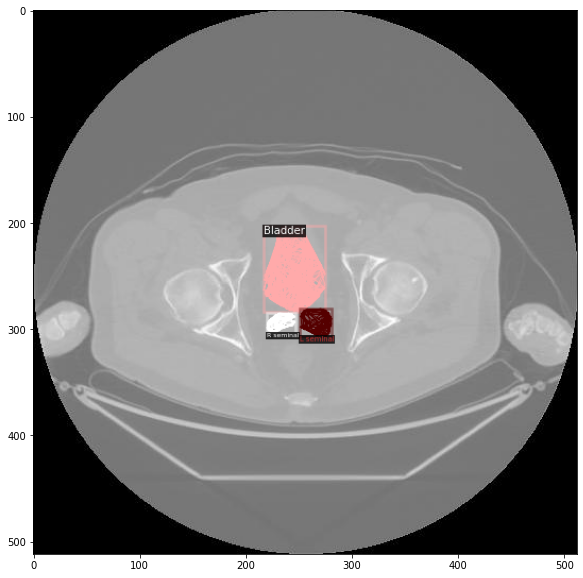

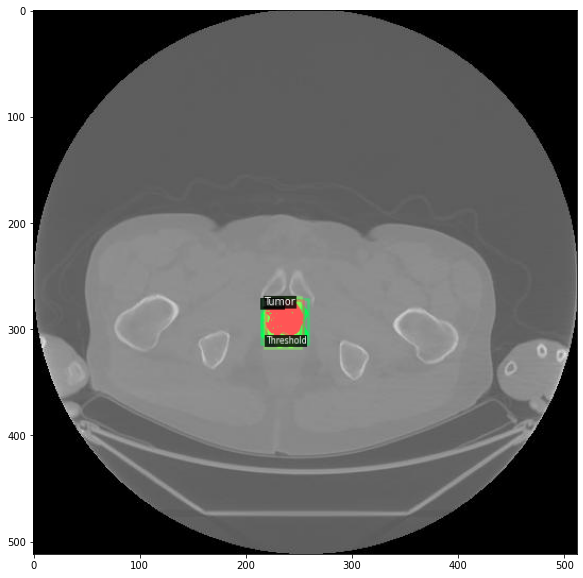

In [24]:
# visualize annotations
for d in random.sample(dataset_dicts, 100):
    if len(d['annotations']) != 0:
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=prostate_metadata, scale=1.0)
        out = visualizer.draw_dataset_dict(d)
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()

In [ ]:
# save dataset dict to disk
with open("detectron2_dict.json", 'w') as f:
    json.dump(dataset_dicts, f, indent=4)

In [ ]:
# check class histogram
# https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.print_instances_class_histogram
# FIXME: nothing seems to happen
print_instances_class_histogram(dataset_dicts, list(thing_classes.keys()))